3 meters across 900 pixels
top width: 731.52 px
bottom width: 899.9999999999999 px
Bottom width in pixels: 900.000000


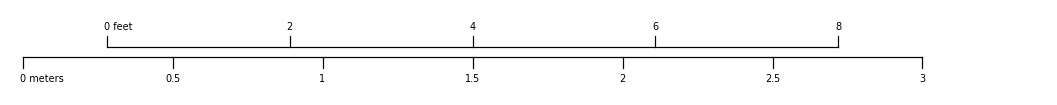

2 meters across 600 pixels
top width: 548.64 px
bottom width: 600.0 px
Bottom width in pixels: 600.000000


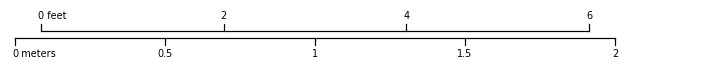

1 meter across 300 pixels
top width: 182.88 px
bottom width: 300.0 px
Bottom width in pixels: 300.000000


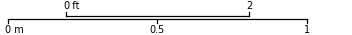

In [36]:
# Thanks to Senshin @ https://stackoverflow.com/a/33947673/706797
def get_first_sig_dig(x):
    from math import log10, floor
    return round(x / (10**floor(log10(x))))

# Thanks to Evgeny and Tobias Kienzler @ https://stackoverflow.com/a/3411435/706797
def round_to_1(x):
    from math import log10, floor
    return round(x, -int(floor(log10(abs(x)))))

def refit_step(step_tick, num_steps, max_width_in_units, min_step_width_in_pixels, units_per_pixel):
    sig_dig = get_first_sig_dig(step_tick)
    if num_steps > 1:
        step_tick = increase_step_size(step_tick, sig_dig)
        num_steps = int(max_width_in_units/step_tick)
    else:
        step_tick = reduce_step_size(step_tick, sig_dig)
        num_steps = int(max_width_in_units/step_tick)
            
    step_width_in_pixels = step_tick/units_per_pixel
    if step_width_in_pixels < min_step_width_in_pixels:
        growth_ratio = int(min_step_width_in_pixels/step_width_in_pixels)+1
        step_tick = step_tick * growth_ratio
        num_steps = int(max_width_in_units/step_tick)
    
    if num_steps < 1:
        # punt and worry about other things.
        step_tick = min_step_width_in_pixels * units_per_pixel
        num_steps = 1
        
    if step_tick > 10:
        step_tick = int(step_tick)

    return {
        'step_tick': step_tick,
        'num_steps': num_steps
    }

def increase_step_size(step_tick, sig_dig):
    if sig_dig in [1,2,5]:
        return step_tick
    elif sig_dig < 5:
        resize_factor = 5/sig_dig
    else:
        resize_factor = 10/sig_dig
            
    new_step_tick = resize_factor * step_tick
    return resize_factor * step_tick

def reduce_step_size(step_tick, sig_dig):
    if sig_dig < 3:
        resize_factor = 0.5
    elif sig_dig < 5:
        resize_factor = 2/sig_dig
    elif sig_dig == 5:
        return step_tick
    else:
        resize_factor = 5/sig_dig
        
    return step_tick * resize_factor
    
def generate_scalebar_ticks(img_width_in_meters, img_width_in_pixels=509, scale_width_ratio=1, min_step_width=100, dpi=300):
    bottom_units_per_pixel = img_width_in_meters/img_width_in_pixels
    if img_width_in_pixels > 500:
        units_bottom = 'meters'
        units_top = 'feet'
    else:
        units_bottom = 'm'
        units_top = 'ft'
    scale_bottom = 1
    scale_top = 0.3048
    scale_width_in_meters = img_width_in_meters*scale_width_ratio
    scale_width_in_pixels = scale_width_in_meters/bottom_units_per_pixel
    max_step_count = int(scale_width_in_pixels/min_step_width)
    num_steps_bottom = max_step_count
    if num_steps_bottom < 1:
        num_steps_bottom = 1
    if scale_width_in_meters/num_steps_bottom > 1000:
        if img_width_in_pixels > 500:
            units_bottom = 'km'
            units_top = 'miles'
        else:
            units_bottom = 'km'
            units_top = 'mi'
        scale_bottom = 1000
        scale_top = 1609.34
    bottom_unit_count = scale_width_in_meters/scale_bottom
    top_unit_count = scale_width_in_meters/scale_top
    step_ticks_bottom = round_to_1(bottom_unit_count/num_steps_bottom)
    
    refit_dict = refit_step(
        step_ticks_bottom, 
        num_steps_bottom, 
        scale_width_in_meters/scale_bottom, 
        min_step_width, 
        bottom_units_per_pixel/scale_bottom
    )
    step_ticks_bottom = refit_dict['step_tick']
    num_steps_bottom = refit_dict['num_steps']
    
    step_ticks_top = round_to_1(top_unit_count/num_steps_bottom)
    num_steps_top = num_steps_bottom
    
    refit_dict = refit_step(
        step_ticks_top, 
        num_steps_top, 
        scale_width_in_meters/scale_top, 
        min_step_width, 
        bottom_units_per_pixel/scale_top
    )
    
    step_ticks_top = refit_dict['step_tick']
    num_steps_top = refit_dict['num_steps']
    
    num_ticks_top = num_steps_top + 1
    num_ticks_bottom = num_steps_bottom + 1
    
    print('top width: %s px' % (num_steps_top * step_ticks_top / (bottom_units_per_pixel/scale_top)))
    print('bottom width: %s px' % (num_steps_bottom * step_ticks_bottom / bottom_units_per_pixel))
    
    
    
    return make_scalebar(
        num_ticks_top,
        step_ticks_top,
        num_ticks_bottom,
        step_ticks_bottom,
        bottom_units_per_pixel,
        scale_top=scale_top,
        scale_bottom=scale_bottom,
        units_top=units_top,
        units_bottom=units_bottom
    )

def format_label(value):
    if int(value) >= 1000:
        return '{:,d}'.format(value)
    # elif type(value) == int or value >= 10:
    #     return str(int(value))
    else:
        # 3 digits should be more than enough - in theory there should only be 1 unless things go sideways
        return '{:.3g}'.format(value)
    

def make_scalebar(num_ticks_top, 
                  step_ticks_top, 
                  num_ticks_bottom, 
                  step_ticks_bottom,
                  bottom_units_per_pixel=None,
                  scale_top=1.0, 
                  scale_bottom=3.28084,
                  units_top='feet', 
                  units_bottom='meters'):
    """Renders a dual scale bar as a PIL Image.
    
    Parameters
    ----------
    num_ticks_top, num_ticks_bottom : int
      number of ticks, including starting and ending points, to use for drawing scale bars
    step_ticks_top, step_ticks_bottom : int
      amount that each successive tick adds to previous tick
    bottom_units_per_pixel : numeric
      the width of each pixel in the resulting image in the same units as
      the bottom scale bar. This parameters helps resize the resulting figure
      to ensure an accurate scale is generated.
    scale_top, scale_bottom : numeric
      relative scales of units in top and bottom scale bars
    units_top, units_bottom : str
      string used to label units on the last tick in the scale bar
      
    Returns
    -------
    img : PIL Image
      the dual scale bar rendered as an in-memory image
    """
    
    
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    DPI = 350
        
    width_top = (num_ticks_top - 1) * step_ticks_top * (scale_top / scale_bottom)
    width_bot = (num_ticks_bottom - 1) * step_ticks_bottom
    min_top, max_top = -width_top / 2, width_top / 2
    min_bot, max_bot = -width_bot / 2, width_bot / 2
    both_min, both_max = min(min_top, min_bot), max(max_top, max_bot)
    
    fig = plt.figure(frameon=False)
    bottom_width_in_pixels = (num_ticks_bottom-1)*step_ticks_bottom/bottom_units_per_pixel
    print("Bottom width in pixels: %f" % bottom_width_in_pixels)
    if bottom_width_in_pixels > 200:
        fig.set_size_inches(1.5, 0.15)
    else:
        print('embiggen')
        fig.set_size_inches(1.5, 0.3)
    fig.dpi = DPI
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # make the top scalebar
    # first, the line
    ax.plot((min_top, max_top), (1.0, 1.0), lw=0.25, color='black')
    # then, create the tick marks
    ticks_top = np.linspace(min_top, max_top, num_ticks_top)
    
    for i, x in enumerate(ticks_top):
        ax.plot((x, x), (1.0, 3.0), lw=0.25, color='black')
        # add the labels for each tick mark
        ax.text(x, 
                4.0, 
                format_label(step_ticks_top*i),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontname='arial',
               fontsize=2)
        # add the units after the last tick mark
        if x == ticks_top[0]:
            spaces = ' ' * (len(format_label(step_ticks_top*i))+1)
            ax.text(x, 
                    4.0, 
                    spaces + units_top,
                    horizontalalignment='left',
                    verticalalignment='bottom', 
                    fontname='arial',
                   fontsize=2)
            
    # make the bottom scalebar
    # first, the line
    ax.plot((min_bot, max_bot), (-1, -1), lw=0.25, color='black')
    # then, create the tick marks
    ticks_bot = np.linspace(min_bot, max_bot, num_ticks_bottom)
    for i, x in enumerate(ticks_bot):
        ax.plot((x, x), (-1.0, -3.0), lw=0.25, color='black')
        # add the labels for each tick mark
        ax.text(x,
                -4.0,
                format_label(step_ticks_bottom*i),
                horizontalalignment='center',
                verticalalignment='top',
                fontname='arial',
                fontsize=2)
         # add the units after the last tick mark
        if x == ticks_bot[0]:
            spaces = ' ' * (len(format_label(step_ticks_bottom*i))+1)
            ax.text(x,
                    -4.0,
                    spaces + units_bottom,
                    horizontalalignment='left',
                    verticalalignment='top',
                    fontname='arial',
                    fontsize=2)
    # set display options so that ticks and labels are appropriately sized
    ax.set_ylim(-10, 10)
    ax.set_xlim(both_min * 1.05, both_max * 1.30)
    ax.axis('off')
    # calculate units per pixel for top scale bar
    img_coords_step_bot = fig.dpi_scale_trans.inverted().transform(
        ax.transData.transform(((ticks_bot[0], 1), (ticks_bot[-1], 1)))) * DPI
    img_scale_bot = (step_ticks_bottom *
                     (num_ticks_bottom - 1)) / (img_coords_step_bot[1][0] -
                                                img_coords_step_bot[0][0])
    # calculate adjustment factor to resize figure to enforce accurate scale
    adjust = img_scale_bot / bottom_units_per_pixel
    fig.set_size_inches(*(fig.get_size_inches() * adjust))
    img = plt_to_pil_image(fig, dpi=DPI)
    return img

def plt_to_pil_image(plt_figure, dpi=200):
    import io
    from PIL import Image
    import matplotlib.pyplot as plt

    fig = plt.figure(plt_figure.number)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=dpi)
    buf.seek(0)
    pil_image = Image.open(buf)
    plt.close()
    return pil_image

print("3 meters across 900 pixels")
foo = generate_scalebar_ticks(3, img_width_in_pixels=900, scale_width_ratio=1, min_step_width=100)
display(foo)

print("2 meters across 600 pixels")
foo = generate_scalebar_ticks(2, img_width_in_pixels=600, scale_width_ratio=1, min_step_width=100)
display(foo)

print("1 meter across 300 pixels")
foo = generate_scalebar_ticks(1, img_width_in_pixels=300, scale_width_ratio=1, min_step_width=100)
display(foo)

# print("1 meter across 1000 pixels")
# foo = generate_scalebar_ticks(1, img_width_in_pixels=1000, scale_width_ratio=1, min_step_width=100)
# display(foo)

# print("3 meters across 500 pixels")
# foo = generate_scalebar_ticks(3, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
# display(foo)

# print("2000 meters across 150 pixels")
# foo = generate_scalebar_ticks(1000, img_width_in_pixels=150, scale_width_ratio=1, min_step_width=100)
# display(foo)

# print("2000 meters across 200 pixels")
# foo = generate_scalebar_ticks(1000, img_width_in_pixels=200, scale_width_ratio=1, min_step_width=100)
# display(foo)

# print("2000 meters across 250 pixels")
# foo = generate_scalebar_ticks(1000, img_width_in_pixels=250, scale_width_ratio=1, min_step_width=100)
# display(foo)

# print("2000 meters across 300 pixels")
# foo = generate_scalebar_ticks(1000, img_width_in_pixels=300, scale_width_ratio=1, min_step_width=100)
# display(foo)